In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_excel('/content/sample_data/AllData.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2714 entries, 0 to 2713
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  2714 non-null   int64         
 1   date        2714 non-null   datetime64[ns]
 2   flux        2714 non-null   float64       
 3   tcc         2714 non-null   float64       
 4   Prod        2608 non-null   float64       
 5   dateString  2714 non-null   object        
 6   doy         2714 non-null   int64         
 7   tod         2714 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 169.8+ KB


In [5]:
X = df[['doy', "tod", 'flux', "tcc"]]
y = df[['Prod', "doy"]]

In [6]:
# interpolation de la prod
y['Prod']=y['Prod'].interpolate()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
days = np.unique(X["doy"])

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
trainDays, testDays = train_test_split(days, test_size=0.2, random_state=0)
trainDays, testDays

(array([351,  34, 205, 221, 112, 360, 186, 224, 192, 200,  15, 322,  18,
        194, 336, 312, 358, 180, 340, 226, 120,  45,  29, 203, 347, 334,
        229, 197,   2, 314, 172, 170,  16,  41,  44, 189, 162, 160,  17,
        191, 350, 211,   1, 151, 127, 193, 153,  56, 144, 317, 195, 313,
        342, 147, 341,  38, 326,  47, 138, 185, 297, 363, 364, 230, 216,
        233,  48, 356, 222, 227,  59, 158, 295, 345, 178, 349, 161, 208,
        196,  31, 346, 309, 217, 306, 157,  49, 298,  25, 344, 361, 212,
        207, 179, 176]),
 array([305, 303, 318,  23, 311,  50,  22,  26, 177, 213, 150, 354,   9,
        187, 365, 223, 140, 174, 301, 225, 204, 343,  43,  58]))

In [10]:
X_train = X[X["doy"].isin(trainDays)]
X_test = X[X["doy"].isin(testDays)]
# X_train = X_train[['flux', "tcc"]]
# X_test = X_test[['flux', "tcc"]]
y_train = y[y["doy"].isin(trainDays)]
y_test = y[y["doy"].isin(testDays)]

In [11]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(verbose=0, n_jobs=8)#random_state=1)
model.fit(X_train, y_train["Prod"])

RandomForestRegressor(n_jobs=8)

In [12]:
y_preds = model.predict(X_test)

In [13]:
from sklearn import metrics

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test["Prod"], y_preds))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test["Prod"], y_preds))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test["Prod"], y_preds)))

Mean Absolute Error (MAE): 0.0841346279491833
Mean Squared Error (MSE): 0.04851705832731396
Root Mean Squared Error (RMSE): 0.2202658809877598


In [14]:
y_train_preds = model.predict(X_train)

In [15]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_train["Prod"], y_train_preds))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_train["Prod"], y_train_preds))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_train["Prod"], y_train_preds)))

Mean Absolute Error (MAE): 0.029273051317614405
Mean Squared Error (MSE): 0.004085508224110031
Root Mean Squared Error (RMSE): 0.06391798044455121


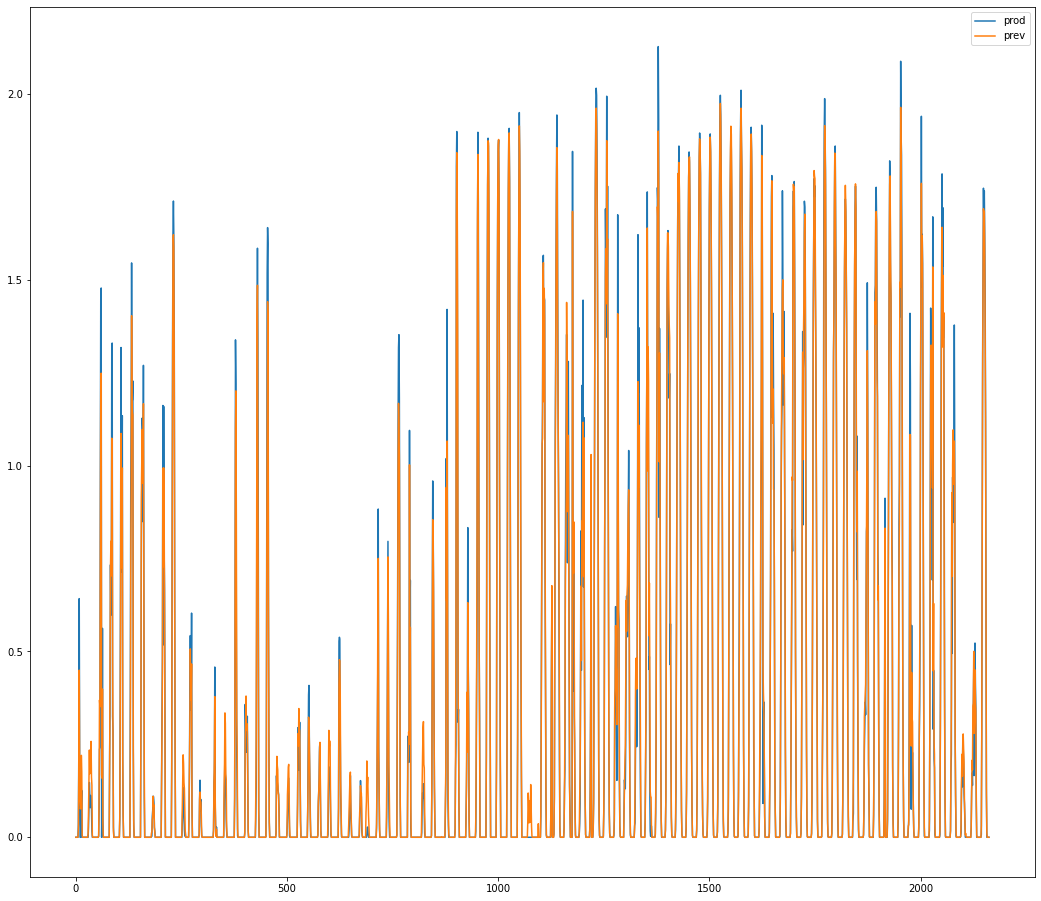

In [17]:
#données d'entrée
import matplotlib.pyplot as plt
plt.figure(figsize=(18,16))
plt.plot(y_train['Prod'].values,label='prod')
plt.plot(y_train_preds,label='prev')
plt.legend()
plt.show()

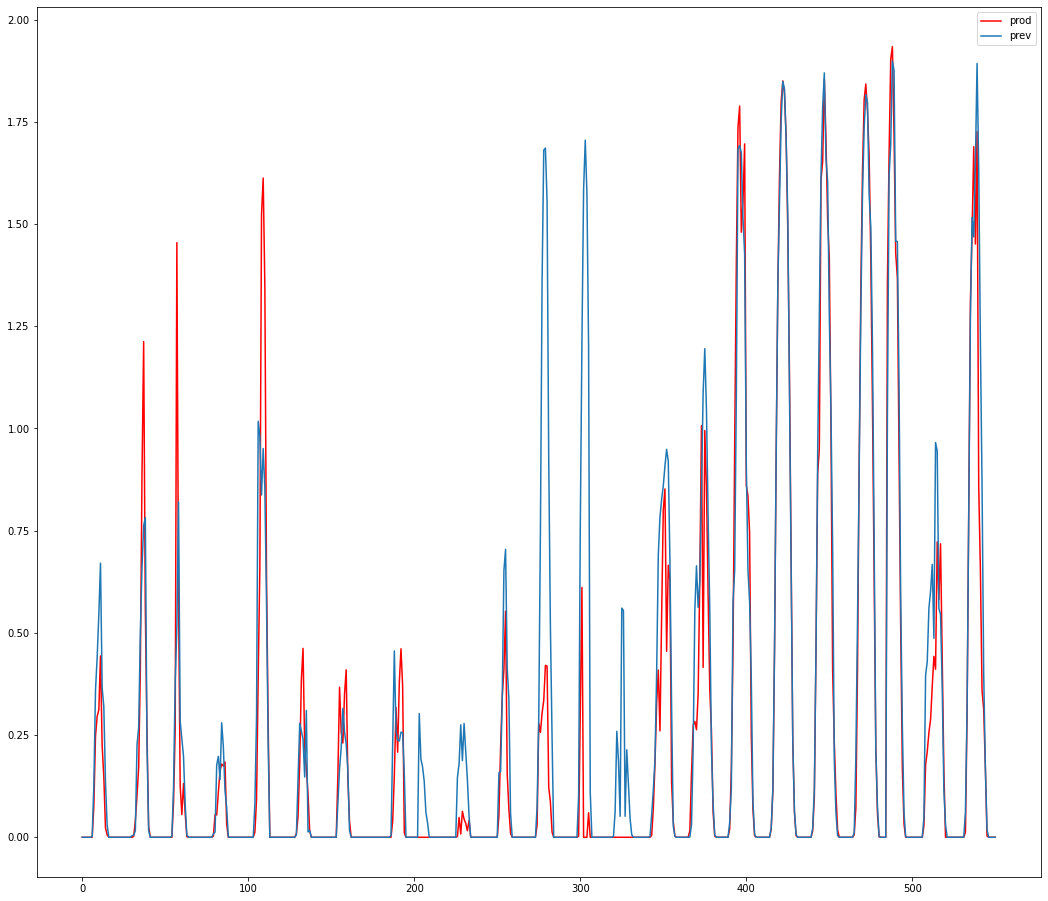

In [18]:
plt.figure(figsize=(18,16))
plt.plot(y_test['Prod'].values, color="red", label='prod')
plt.plot(y_preds, label='prev')
plt.legend()
plt.show()

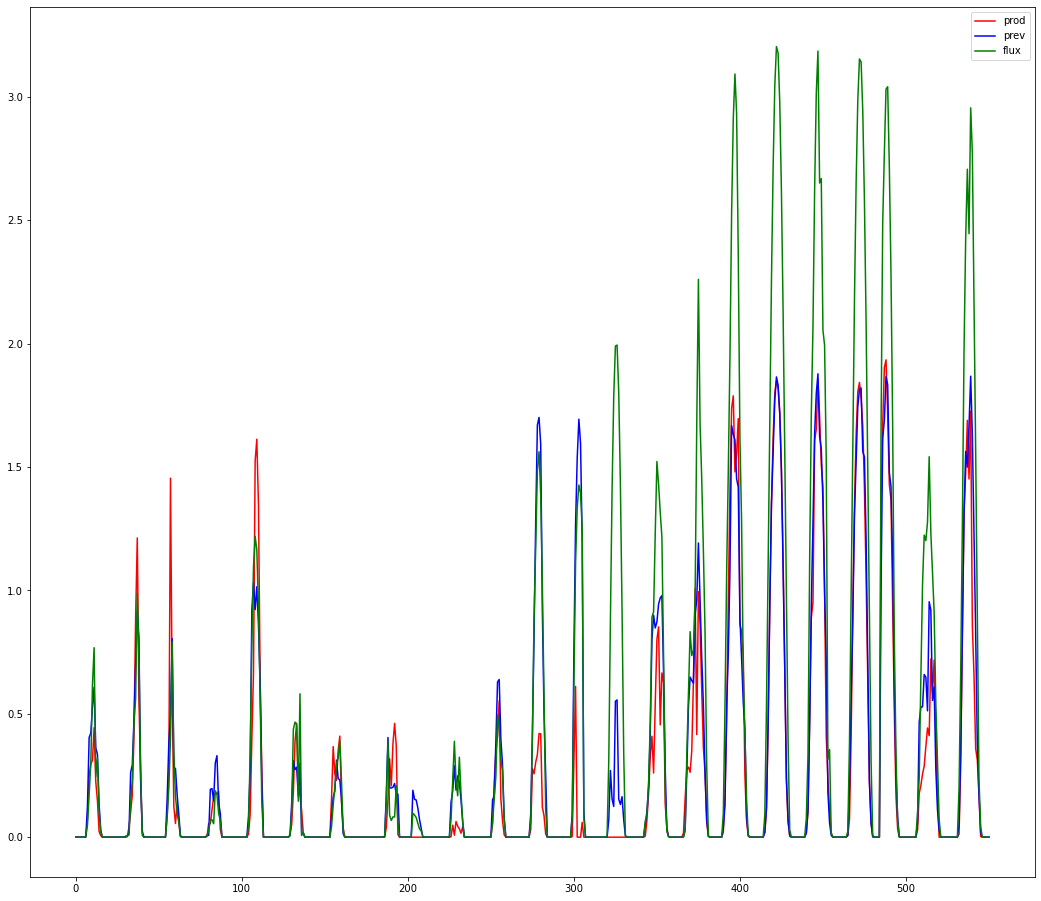

In [ ]:
plt.figure(figsize=(18,16))
plt.plot(y_test['Prod'].values, color = "red", label= 'prod')
plt.plot(y_preds, color="blue", label = 'prev')
plt.plot(X_test['flux'].values/1e6, color ="green", label= 'flux')
plt.legend()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test["Prod"], n_repeats=10, n_jobs=8
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

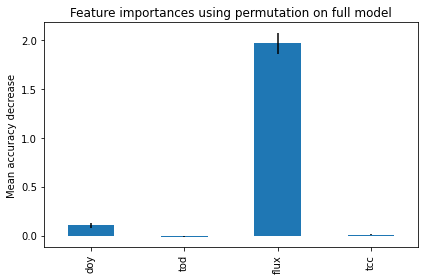

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

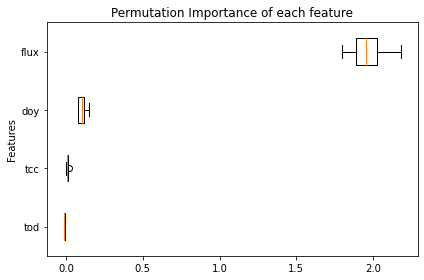

<Figure size 1296x1152 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
plt.figure(figsize=(18,16))

sorted_idx = result.importances_mean.argsort()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importance of each feature")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

# Validation croisée

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True)
y_pred_all = np.zeros(len(y["doy"]))
for train, test in kf.split(days):
     trainDays = days[train]
     testDays = days[test]
     X_train = X[X["doy"].isin(trainDays)]
     X_test = X[X["doy"].isin(testDays)]
     # X_train = X_train[['flux']] #, "tcc"
     # X_test = X_test[['flux']]
     y_train = y[y["doy"].isin(trainDays)]
     y_test = y[y["doy"].isin(testDays)]
     model = RandomForestRegressor(verbose=0, n_jobs=8)#random_state=1)
     model.fit(X_train, y_train["Prod"])
     y_pred_all[y["doy"].isin(testDays)] = model.predict(X_test)

In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y["Prod"], y_pred_all))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y["Prod"], y_pred_all))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y["Prod"], y_pred_all)))

Mean Absolute Error (MAE): 0.0897440309506264
Mean Squared Error (MSE): 0.041708165980305835
Root Mean Squared Error (RMSE): 0.204225772076655


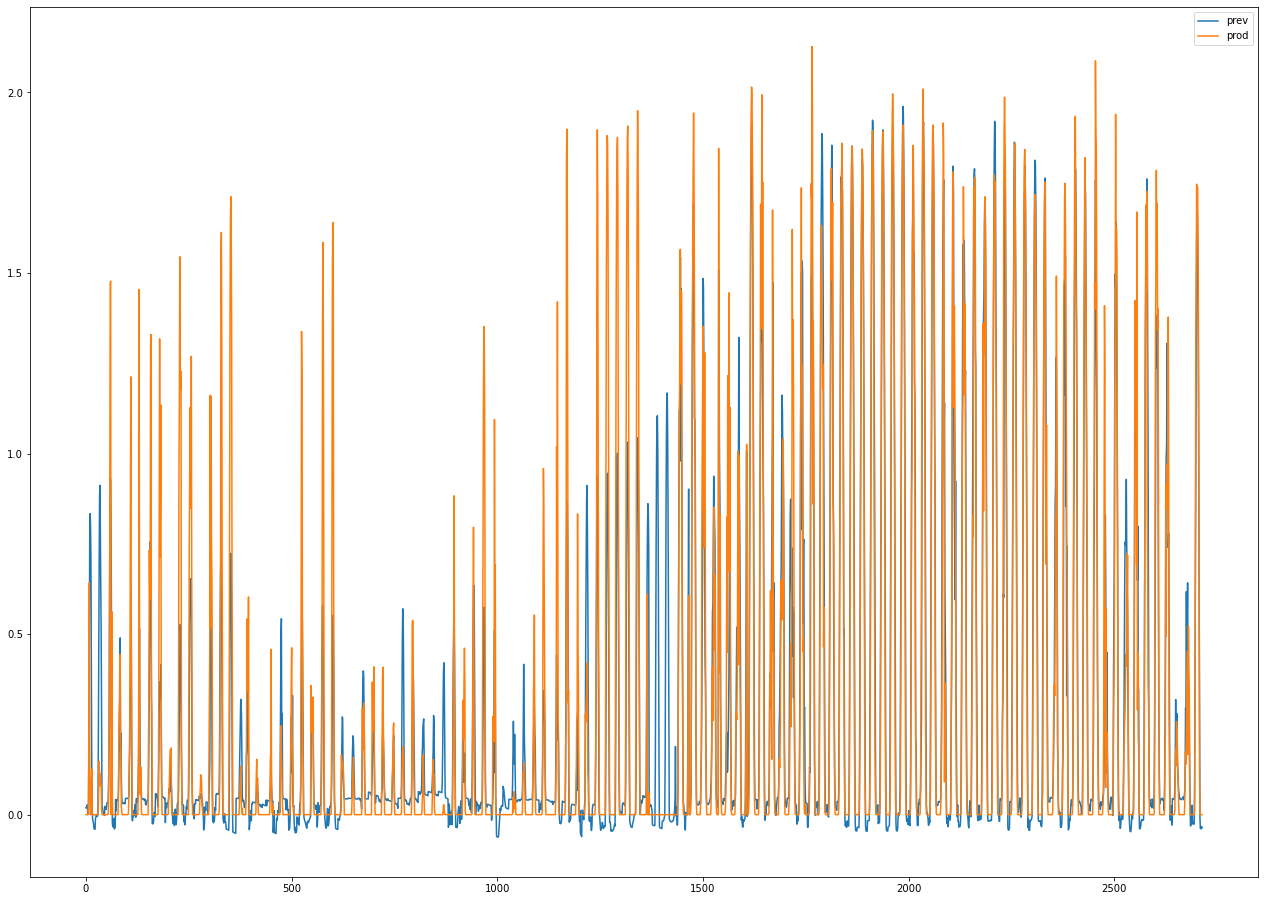

In [ ]:
plt.figure(figsize=(22,16))
plt.plot(y_pred_all,label='prev')
plt.plot(y["Prod"],  label='prod')
plt.legend()
plt.show()

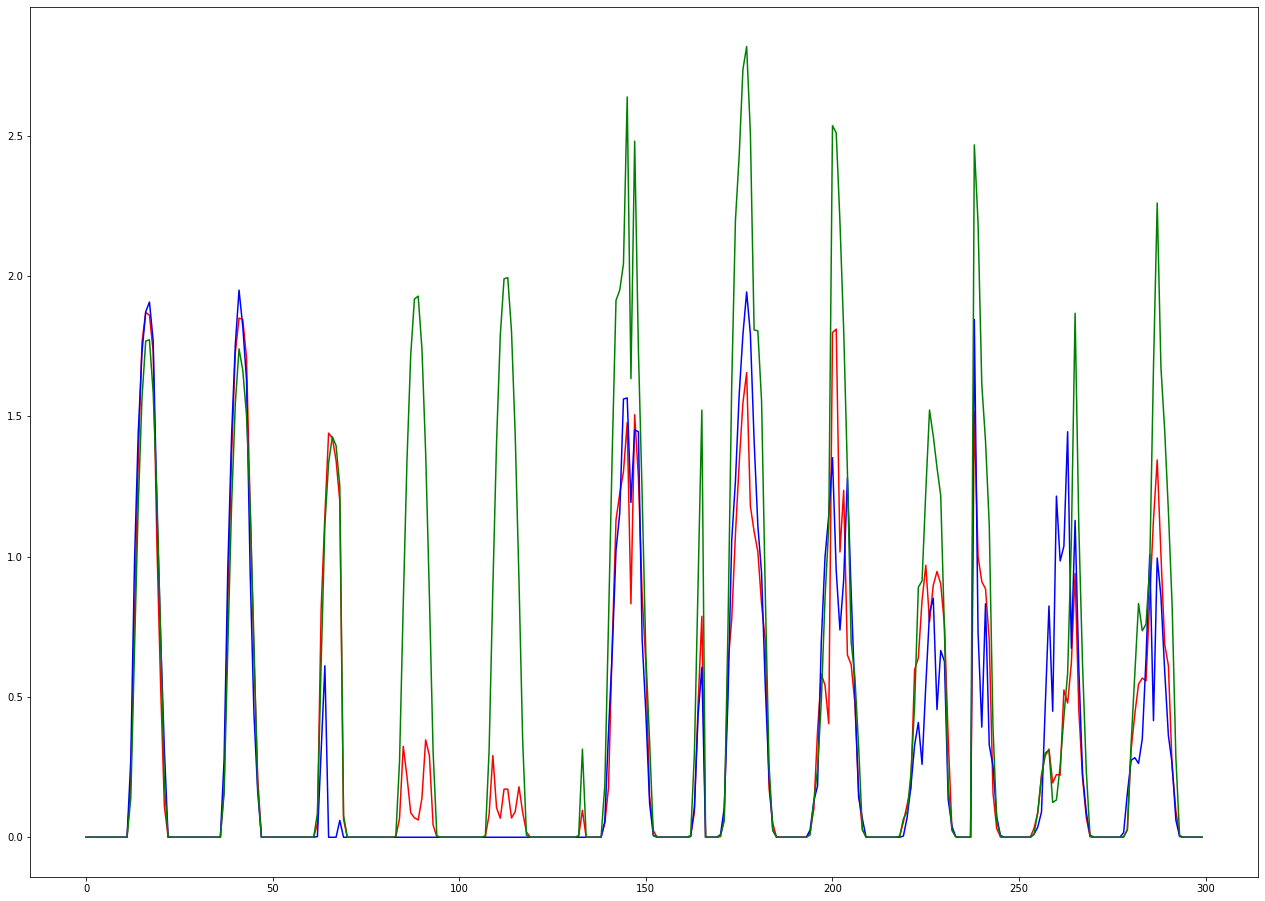

In [ ]:
start = 1300
end = 1600

plt.figure(figsize=(22,16))
plt.plot(y_pred_all[start:end], color="red")
plt.plot(y["Prod"][start:end].values, color="blue")
plt.plot(X['flux'][start:end].values/1e6, color="green")
plt.show()

# Test avec modèle linéaire (pour test)

In [ ]:
from sklearn.linear_model import LinearRegression
kf = KFold(n_splits=4, shuffle=True)
y_pred_all = np.zeros(len(y["doy"]))
for train, test in kf.split(days):
     trainDays = days[train]
     testDays = days[test]
     X_train = X[X["doy"].isin(trainDays)]
     X_test = X[X["doy"].isin(testDays)]
     # X_train = X_train[['flux']] #, "tcc"
     # X_test = X_test[['flux']]
     y_train = y[y["doy"].isin(trainDays)]
     y_test = y[y["doy"].isin(testDays)]
     model = LinearRegression()#random_state=1)
     model.fit(X_train, y_train["Prod"])
     y_pred_all[y["doy"].isin(testDays)] = model.predict(X_test)

In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y["Prod"], y_pred_all))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y["Prod"], y_pred_all))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y["Prod"], y_pred_all)))

Mean Absolute Error (MAE): 0.11447714396671468
Mean Squared Error (MSE): 0.0488657304348294
Root Mean Squared Error (RMSE): 0.2210559441291489


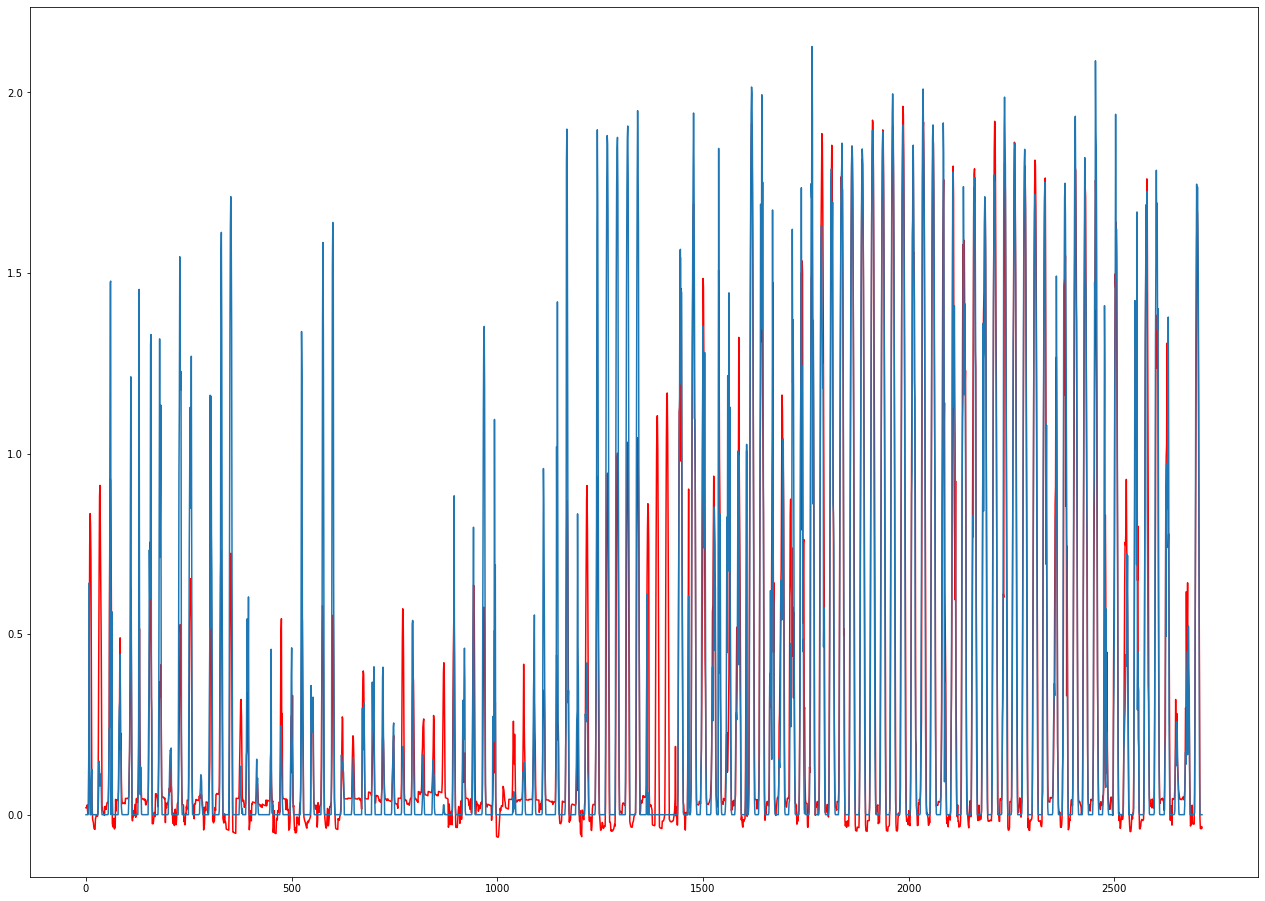

In [ ]:
plt.figure(figsize=(22,16))
plt.plot(y_pred_all, color="red",)
plt.plot(y["Prod"])
plt.show()

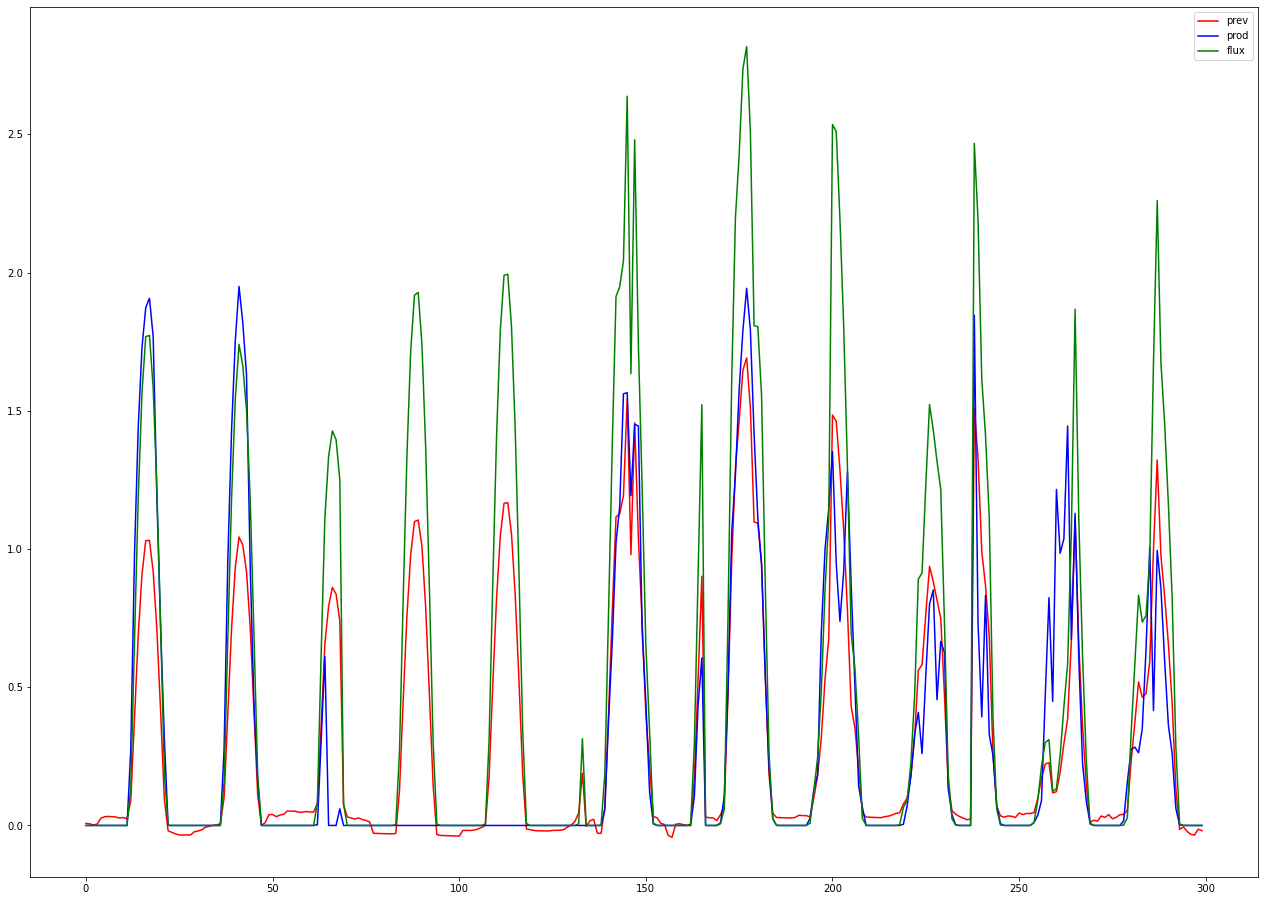

In [ ]:
start = 1300
end = 1600

plt.figure(figsize=(22,16))
plt.plot(y_pred_all[start:end], color="red",label='prev')
plt.plot(y["Prod"][start:end].values, color="blue", label='prod')
plt.plot(X['flux'][start:end].values/1e6, color="green", label='flux')
plt.legend()
plt.show()

# Couplage linéaire + RF (pour test)

In [ ]:
kf = KFold(n_splits=4, shuffle=True)
y_pred_all = np.zeros(len(y["doy"]))
for train, test in kf.split(days):
     trainDays = days[train]
     testDays = days[test]
     X_train = X[X["doy"].isin(trainDays)]
     X_test = X[X["doy"].isin(testDays)]
     # X_train = X_train[['flux']] #, "tcc"
     # X_test = X_test[['flux']]
     y_train = y[y["doy"].isin(trainDays)]
     y_test = y[y["doy"].isin(testDays)]
     model = LinearRegression()#random_state=1)
     model.fit(X_train, y_train["Prod"])
     yLin_train = model.predict(X_train)
     yLin_test = model.predict(X_test)
     X_train["lin"] = yLin_train
     X_test["lin"] = yLin_test
     X_train = X_train[['tod', "doy", "lin"]] #, "tcc"
     X_test = X_test[['tod', "doy", "lin"]]
     modelRF = RandomForestRegressor(verbose=0, n_jobs=8)#random_state=1)
     modelRF.fit(X_train, y_train["Prod"])
     y_pred_all[y["doy"].isin(testDays)] = modelRF.predict(X_test)

<ipython-input-35-a20e0a1259eb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["lin"] = yLin_train
<ipython-input-35-a20e0a1259eb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["lin"] = yLin_test
<ipython-input-35-a20e0a1259eb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y["Prod"], y_pred_all))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y["Prod"], y_pred_all))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y["Prod"], y_pred_all)))

Mean Absolute Error (MAE): 0.09425017870302137
Mean Squared Error (MSE): 0.04824761206179993
Root Mean Squared Error (RMSE): 0.21965339073595


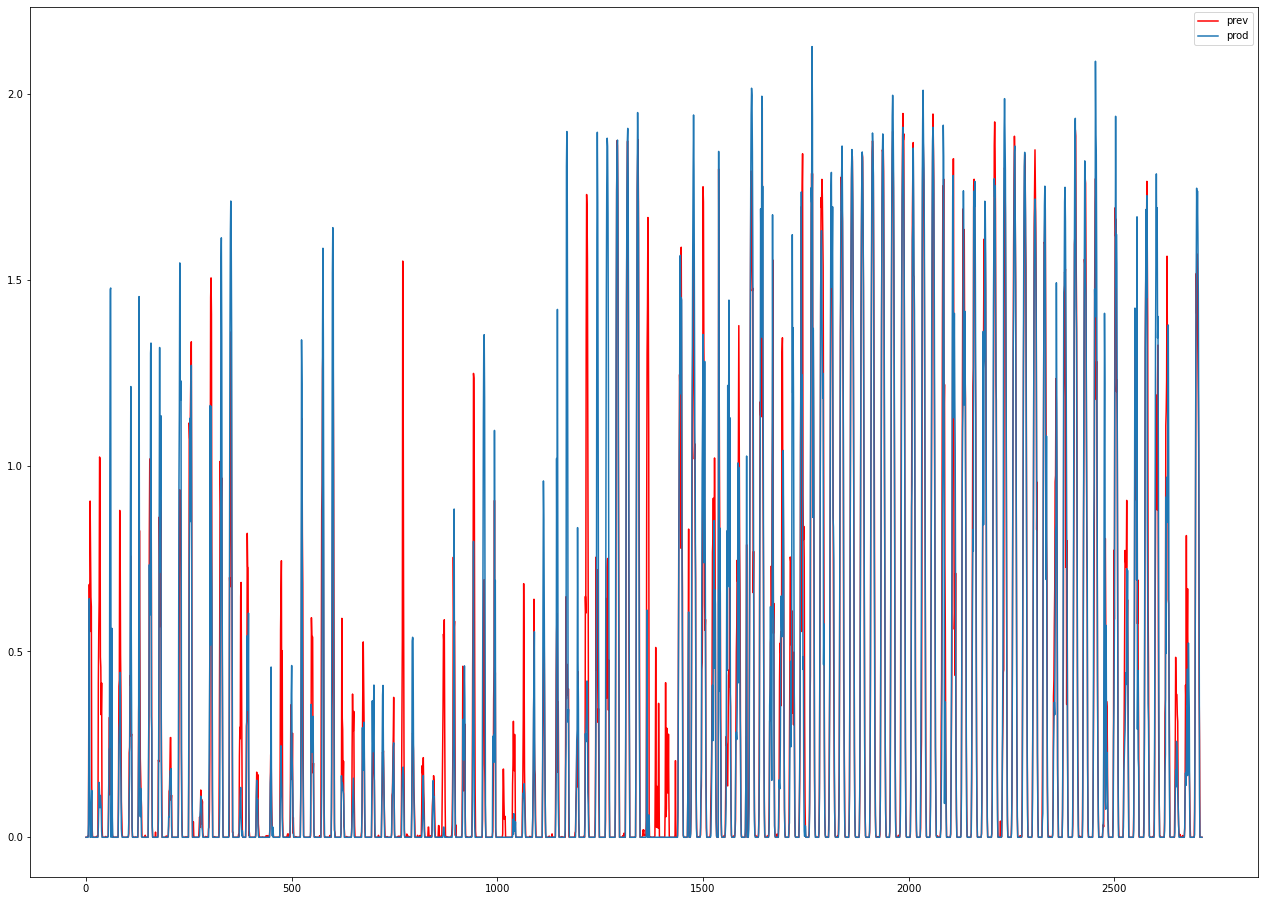

In [ ]:
plt.figure(figsize=(22,16))
plt.plot(y_pred_all, color="red", label='prev')
plt.plot(y["Prod"],label='prod')
plt.legend()
plt.show()

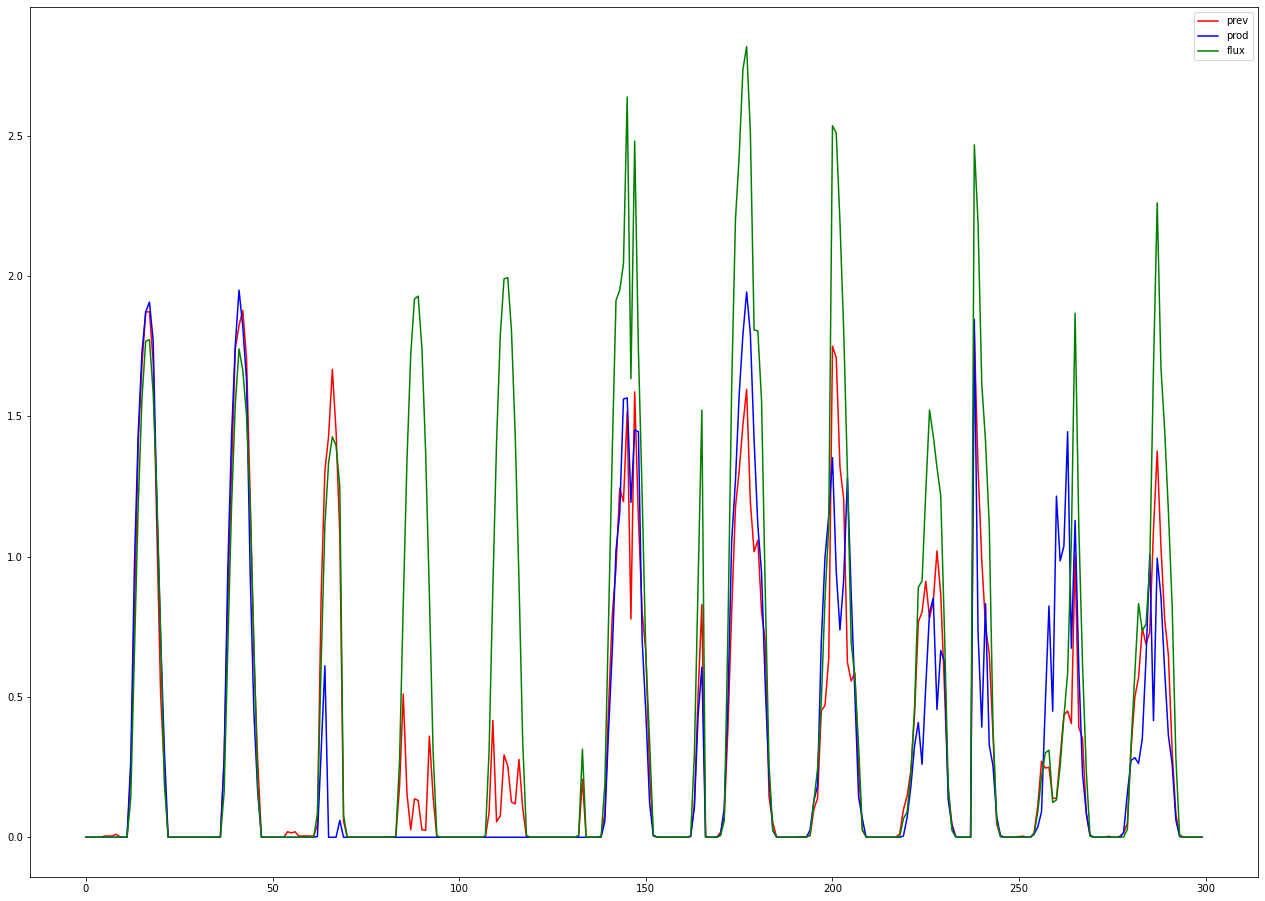

In [ ]:
start = 1300
end = 1600

plt.figure(figsize=(22,16))
plt.plot(y_pred_all[start:end], color="red", label='prev')
plt.plot(y["Prod"][start:end].values, color="blue",label='prod')
plt.plot(X['flux'][start:end].values/1e6, color="green", label='flux')
plt.legend()
plt.show()

# Mise en forme des données

In [ ]:
df

,Unnamed: 0,date,flux,tcc,Prod,dateString,doy,tod
0,0,2018-10-22 00:00:00,5.170000e-11,7.500000e+01,0.0,2018-10-22 00:00:00,295,0
1,1,2018-10-22 01:00:00,5.170000e-11,7.550000e+01,0.0,2018-10-22 01:00:00,295,1
2,2,2018-10-22 02:00:00,5.170000e-11,8.350000e+01,0.0,2018-10-22 02:00:00,295,2
3,3,2018-10-22 03:00:00,2.402496e-01,8.900000e+01,0.0,2018-10-22 03:00:00,295,3
4,4,2018-10-22 04:00:00,3.759750e+00,6.100000e+01,0.0,2018-10-22 04:00:00,295,4
...,...,...,...,...,...,...,...,...
2709,2709,2019-08-21 19:00:00,8.256250e+01,1.000000e-08,0.0,2019-08-21 19:00:00,233,19
2710,2710,2019-08-21 20:00:00,0.000000e+00,1.000000e-08,0.0,2019-08-21 20:00:00,233,20
2711,2711,2019-08-21 21:00:00,0.000000e+00,1.000000e-08,0.0,2019-08-21 21:00:00,233,21
2712,2712,2019-08-21 22:00:00,0.000000e+00,1.050000e+01,0.0,2019-08-21 22:00:00,233,22


In [ ]:
df["prevision"] = y_pred_all

In [ ]:
df

,Unnamed: 0,date,flux,tcc,Prod,dateString,doy,tod,prevision
0,0,2018-10-22 00:00:00,5.170000e-11,7.500000e+01,0.0,2018-10-22 00:00:00,295,0,0.000000
1,1,2018-10-22 01:00:00,5.170000e-11,7.550000e+01,0.0,2018-10-22 01:00:00,295,1,0.000060
2,2,2018-10-22 02:00:00,5.170000e-11,8.350000e+01,0.0,2018-10-22 02:00:00,295,2,0.000000
3,3,2018-10-22 03:00:00,2.402496e-01,8.900000e+01,0.0,2018-10-22 03:00:00,295,3,0.000060
4,4,2018-10-22 04:00:00,3.759750e+00,6.100000e+01,0.0,2018-10-22 04:00:00,295,4,0.002800
...,...,...,...,...,...,...,...,...,...
2709,2709,2019-08-21 19:00:00,8.256250e+01,1.000000e-08,0.0,2019-08-21 19:00:00,233,19,0.000100
2710,2710,2019-08-21 20:00:00,0.000000e+00,1.000000e-08,0.0,2019-08-21 20:00:00,233,20,0.000010
2711,2711,2019-08-21 21:00:00,0.000000e+00,1.000000e-08,0.0,2019-08-21 21:00:00,233,21,0.000000
2712,2712,2019-08-21 22:00:00,0.000000e+00,1.050000e+01,0.0,2019-08-21 22:00:00,233,22,0.000000


In [ ]:
df.to_excel("PrevisionsRenardieres.xlsx")

# Ajout des prévisions "sans réalisé"

In [ ]:
dfFlux = pd.read_csv("DataRenardieres/flux.csv", sep=";", decimal=",")
dfFlux["date"] = pd.to_datetime(dfFlux["date"])
dfFlux["doy"] = dfFlux["date"].dt.strftime("%j")
dfFlux["tod"] = dfFlux["date"].dt.strftime("%H")

dfTcc = pd.read_csv("DataRenardieres/tcc.csv", sep=";", decimal=",")
dfTcc["date"] = pd.to_datetime(dfTcc["date"])

data = pd.merge(dfFlux, dfTcc)

In [ ]:
dfFlux

,date,flux,doy,tod
0,2016-12-24 00:00:00,4.040000e-12,359,00
1,2016-12-24 01:00:00,4.040000e-12,359,01
2,2016-12-24 02:00:00,4.040000e-12,359,02
3,2016-12-24 03:00:00,-8.296967e-03,359,03
4,2016-12-24 04:00:00,-1.804203e+00,359,04
...,...,...,...,...
20683,2020-06-09 19:00:00,1.024000e+04,161,19
20684,2020-06-09 20:00:00,0.000000e+00,161,20
20685,2020-06-09 21:00:00,0.000000e+00,161,21
20686,2020-06-09 22:00:00,0.000000e+00,161,22


In [ ]:
y_pred_allFlux = model.predict(data[['doy', "tod", 'flux', "tcc"]])

In [ ]:
y_pred_allFlux

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
data["prevision_trous"] = y_pred_allFlux

In [ ]:
dataFinal = pd.merge(data, df, how="outer", on="date")

In [ ]:
dataFinal

,date,flux_x,doy_x,tod_x,tcc_x,prevision_trous,Unnamed: 0,flux_y,tcc_y,Prod,dateString,doy_y,tod_y
0,2016-12-24 00:00:00,4.040000e-12,359,00,100.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-12-24 01:00:00,4.040000e-12,359,01,100.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-12-24 02:00:00,4.040000e-12,359,02,100.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-12-24 03:00:00,-8.296967e-03,359,03,100.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-12-24 04:00:00,-1.804203e+00,359,04,100.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21477,2020-06-09 19:00:00,1.024000e+04,161,19,85.0,0.004595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21478,2020-06-09 20:00:00,0.000000e+00,161,20,74.5,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21479,2020-06-09 21:00:00,0.000000e+00,161,21,52.5,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21480,2020-06-09 22:00:00,0.000000e+00,161,22,67.5,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dataFinal.to_excel("PrevisionsRenardieresAvecTrous.xlsx")